In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

from analysis_helpers import poisson_waiting_function, \
                            run_multiple_trajectories, \
                            plot_aip_vs_t, \
                            plot_cip_vs_t, \
                            run_sensitivity_sims, \
                            extract_cips

from stochastic_simulation import StochasticSimulation
from sir_stochastic_sim import SIRStochasticSimulation

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 12

def plot_trajectories(dfs, title, params, color='green', ID_only=False):
    plt.xlabel("Day")
    plt.ylabel("Number of Active Infections")
    plt.title(title)
    for df in dfs:
        add_plot(df, params, color=color, ID_only=ID_only)

def add_plot(df, params, color='blue', ID_only=False):
    if ID_only:
        cols = ['ID_{}'.format(x) for x in range(params['max_time_ID'])]
    else:
        cols = ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])]
    plt.plot(df[cols].sum(axis=1), linewidth=10.0, alpha=0.1, color=color)    


# Running a Trajectory

In [43]:
# what percent of self-reports are from severe symptoms?  
# in reality I think this value will vary a lot in the first few days, 
# and then reach some kind of steady-state, and I'm not sure what makes the most
# sense to use here.  I am setting it to the very pessimistic value of 100% of
# self-reporters are severe, which yields the smallest infectious window size
pct_self_reports_severe = 0.6

daily_self_report_severe = 0.85
daily_self_report_mild = 0.1

# avg_infectious_window = (avg time in ID state) + (avg time in Sy state prior to self-reporting)
avg_infectious_window = 4 + pct_self_reports_severe * (1 / daily_self_report_severe) + \
                        (1-pct_self_reports_severe) * (1 / daily_self_report_mild)
print(avg_infectious_window)
pre_reopen_population = 1500
pre_reopen_daily_contacts = 7

reopen_population = 2500
reopen_daily_contacts = 10

base_params = {
    'max_time_exposed': 4,
    'exposed_time_function': poisson_waiting_function(max_time=4, mean_time=1),
    
    'max_time_pre_ID': 4,
    'pre_ID_time_function': poisson_waiting_function(max_time=4, mean_time=1),
    
    'max_time_ID': 8,
    'ID_time_function': poisson_waiting_function(max_time=8, mean_time=4),
    
    'max_time_SyID_mild': 14,
    'SyID_mild_time_function': poisson_waiting_function(max_time=14, mean_time=10),
    
    'max_time_SyID_severe': 14,
    'SyID_severe_time_function': poisson_waiting_function(max_time=14, mean_time=10),
    
    'sample_QI_exit_function': (lambda n: np.random.binomial(n, 0.05)),
    'sample_QS_exit_function': (lambda n: np.random.binomial(n, 0.3)),
    
    'exposed_infection_p': 0.026,
    'expected_contacts_per_day': 100,
    
    'mild_symptoms_p': 0.4,
    'mild_symptoms_daily_self_report_p': daily_self_report_mild,
    'severe_symptoms_daily_self_report_p': daily_self_report_severe,
    
    'days_between_tests': 300,
    'test_population_fraction': 0,
    
    'test_protocol_QFNR': 0.1,
    'test_protocol_QFPR': 0.005,
    
    'perform_contact_tracing': True,
    'contact_tracing_constant': 0.5,
    'contact_tracing_delay': 1,
    'contact_trace_infectious_window': avg_infectious_window,
    
    'pre_ID_state': 'detectable',
    
    'population_size': pre_reopen_population,
    'initial_E_count': 0,
    'initial_pre_ID_count': 45,
    'initial_ID_count': 0,
    'initial_ID_prevalence': 0.001,
    'initial_SyID_mild_count': 0,
    'initial_SyID_severe_count': 0
}


8.705882352941178


In [44]:
# base_params
dfs_sims = run_multiple_trajectories(base_params, ntrajectories=50, time_horizon=150)

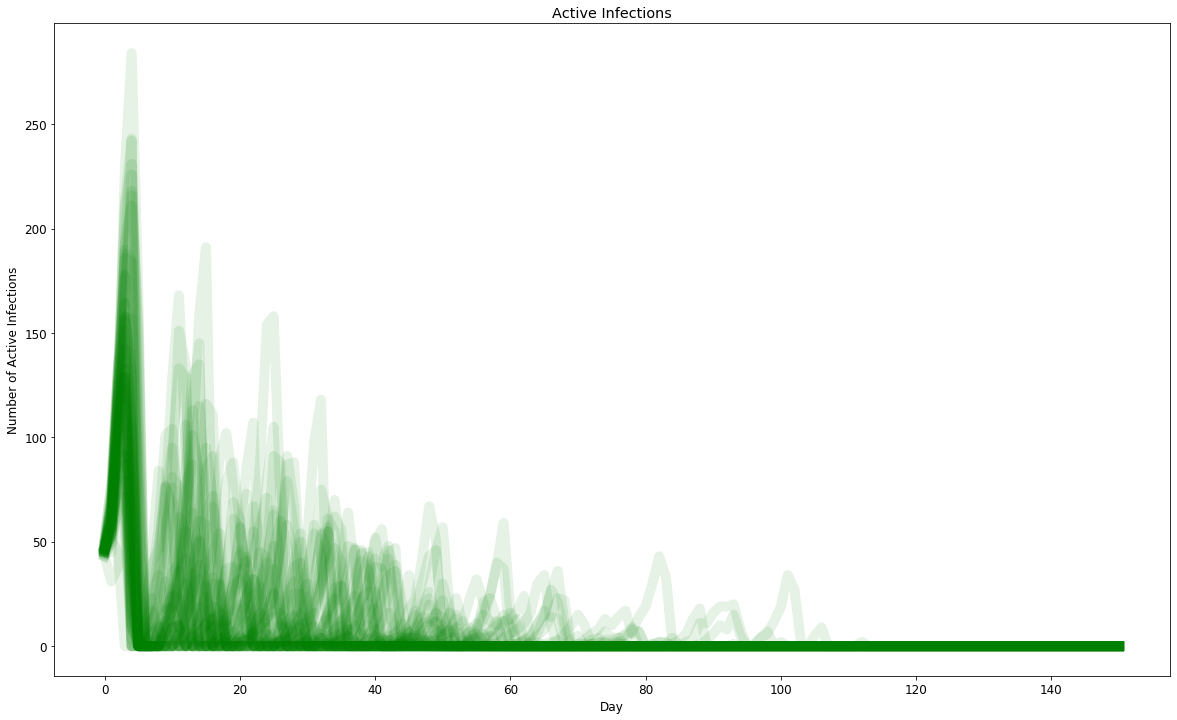

In [45]:
plt.figure(figsize=(20,12))
plot_trajectories(dfs_sims, 'Active Infections', base_params)

# Continuous vs. All at once testing

In [40]:
cont_testing_params = base_params.copy()
all_at_once_params = base_params.copy()

test_frequency = 10

cont_testing_params['days_between_tests'] = 1
cont_testing_params['test_population_fraction'] = 1/test_frequency

all_at_once_params['days_between_tests'] = test_frequency
all_at_once_params['test_population_fraction'] = 1

In [41]:
dfs_cont_testing = run_multiple_trajectories(cont_testing_params, ntrajectories=50, time_horizon=150)
dfs_all_at_once = run_multiple_trajectories(all_at_once_params, ntrajectories=50, time_horizon=150)

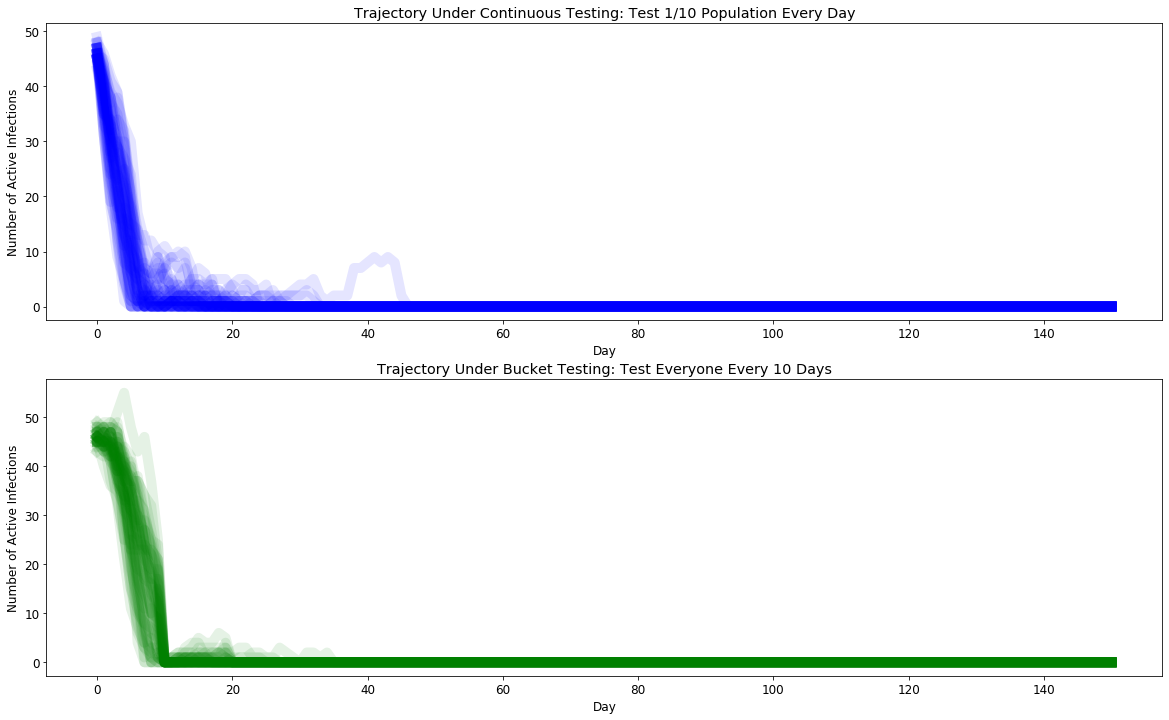

In [42]:
title_cts = "Trajectory Under Continuous Testing: Test 1/{} Population Every Day".format(test_frequency)
title_bucket = "Trajectory Under Bucket Testing: Test Everyone Every {} Days".format(test_frequency)

plt.figure(figsize=(20,12))

plt.subplot(2,1,1)
plot_trajectories(dfs_cont_testing, title_cts, cont_testing_params, 'blue')

plt.subplot(2,1,2)
plot_trajectories(dfs_all_at_once, title_bucket, all_at_once_params)

plt.show()

# Sensitivity Analysis for Reopen

In [19]:
# what percent of self-reports are from severe symptoms?  
# in reality I think this value will vary a lot in the first few days, 
# and then reach some kind of steady-state, and I'm not sure what makes the most
# sense to use here.  I am setting it to the very pessimistic value of 100% of
# self-reporters are severe, which yields the smallest infectious window size
pct_self_reports_severe = 0.6

daily_self_report_severe = 0.85
daily_self_report_mild = 0.1

# avg_infectious_window = (avg time in ID state) + (avg time in Sy state prior to self-reporting)
avg_infectious_window = 4 + pct_self_reports_severe * (1 / daily_self_report_severe) + \
                        (1-pct_self_reports_severe) * (1 / daily_self_report_mild)
print(avg_infectious_window)
pre_reopen_population = 1500
pre_reopen_daily_contacts = 7

reopen_population = 2500
reopen_daily_contacts = 10

pre_reopen_params = {
    'max_time_exposed': 4,
    'exposed_time_function': poisson_waiting_function(max_time=4, mean_time=1),
    
    'max_time_pre_ID': 4,
    'pre_ID_time_function': poisson_waiting_function(max_time=4, mean_time=1),
    
    'max_time_ID': 8,
    'ID_time_function': poisson_waiting_function(max_time=8, mean_time=4),
    
    'max_time_SyID_mild': 14,
    'SyID_mild_time_function': poisson_waiting_function(max_time=14, mean_time=10),
    
    'max_time_SyID_severe': 14,
    'SyID_severe_time_function': poisson_waiting_function(max_time=14, mean_time=10),
    
    'sample_QI_exit_function': (lambda n: np.random.binomial(n, 0.05)),
    'sample_QS_exit_function': (lambda n: np.random.binomial(n, 0.3)),
    
    'exposed_infection_p': 0.026,
    'expected_contacts_per_day': pre_reopen_daily_contacts,
    
    'mild_symptoms_p': 0.4,
    'mild_symptoms_daily_self_report_p': daily_self_report_mild,
    'severe_symptoms_daily_self_report_p': daily_self_report_severe,
    
    'days_between_tests': 300,
    'test_population_fraction': 0,
    
    'test_protocol_QFNR': 0.1,
    'test_protocol_QFPR': 0.005,
    
    'perform_contact_tracing': True,
    'contact_tracing_constant': 0.5,
    'contact_tracing_delay': 1,
    'contact_trace_infectious_window': avg_infectious_window,
    
    'pre_ID_state': 'detectable',
    
    'population_size': pre_reopen_population,
    'initial_E_count': 0,
    'initial_pre_ID_count': 2,
    'initial_ID_count': 0,
    'initial_ID_prevalence': 0.001,
    'initial_SyID_mild_count': 0,
    'initial_SyID_severe_count': 0
}

reopen_params = pre_reopen_params.copy()
reopen_params['population_size'] = reopen_population
reopen_params['expected_contacts_per_day'] = reopen_daily_contacts

8.705882352941178


In [20]:
prevalence_range = [0.0005, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
dfs_prevalence_pre_reopen = run_sensitivity_sims(pre_reopen_params, param_to_vary='initial_ID_prevalence',
                                     param_values = prevalence_range, trajectories_per_config=250, time_horizon=100)
dfs_prevalence_post_reopen = run_sensitivity_sims(reopen_params, param_to_vary='initial_ID_prevalence',
                                     param_values = prevalence_range, trajectories_per_config=250, time_horizon=100)

Done simulating initial_ID_prevalence equal to 0.0005
Done simulating initial_ID_prevalence equal to 0.001
Done simulating initial_ID_prevalence equal to 0.005
Done simulating initial_ID_prevalence equal to 0.01
Done simulating initial_ID_prevalence equal to 0.02
Done simulating initial_ID_prevalence equal to 0.03
Done simulating initial_ID_prevalence equal to 0.04
Done simulating initial_ID_prevalence equal to 0.05
Done simulating initial_ID_prevalence equal to 0.0005
Done simulating initial_ID_prevalence equal to 0.001
Done simulating initial_ID_prevalence equal to 0.005
Done simulating initial_ID_prevalence equal to 0.01
Done simulating initial_ID_prevalence equal to 0.02
Done simulating initial_ID_prevalence equal to 0.03
Done simulating initial_ID_prevalence equal to 0.04
Done simulating initial_ID_prevalence equal to 0.05


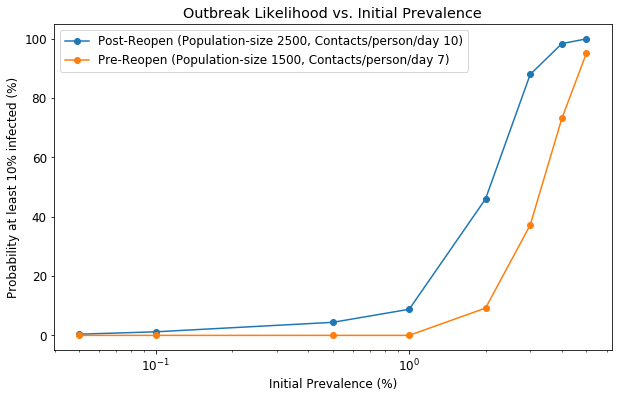

In [21]:
import matplotlib.pyplot as plt
def plot_many_dfs_threshold(dfs_dict, threshold=0.1, xlabel="", title="", figsize=(10,6)):
    plt.figure(figsize=figsize)
    for df_label, dfs_varied in dfs_dict.items():
        p_thresholds = []
        xs = sorted(list(dfs_varied.keys()))
        for x in xs:
            cips = extract_cips(dfs_varied[x])
            cip_exceed_thresh = [cip for cip in cips if cip >= threshold]
            p_thresholds.append(len(cip_exceed_thresh) / len(cips) * 100)
        plt.plot([x * 100 for x in xs], p_thresholds, marker='o', label=df_label)
    plt.xlabel(xlabel)
    plt.xscale("log")
    plt.ylabel("Probability at least {:.0f}% infected (%)".format(threshold * 100))
    plt.title(title)
    plt.legend(loc='best')
    plt.show()

title = """Outbreak Likelihood vs. Initial Prevalence"""
plot_many_dfs_threshold({'Post-Reopen (Population-size 2500, Contacts/person/day 10)': dfs_prevalence_post_reopen,
                         'Pre-Reopen (Population-size 1500, Contacts/person/day 7)': dfs_prevalence_pre_reopen, 
                         }, 
                        xlabel="Initial Prevalence (%)",
                       title=title)